In [11]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [12]:
# True weights and starting weights

np.random.seed(17)

d1 = 10
d2 = 1

m_true = 20
A_true = np.random.randn(m_true,d1)*np.sqrt(2/m_true)
B_true = np.random.randn(m_true,m_true)*np.sqrt(2/m_true)
C_true = np.random.randn(d2,m_true)*np.sqrt(1/d2)

m = 10
A0 = np.random.randn(m,d1)*np.sqrt(2/m)
B0 = np.random.randn(m,m)*np.sqrt(2/m)
C0 = np.random.randn(d2,m)*np.sqrt(1/d2)

In [13]:
def relu(x):
    y = np.maximum(0,x)
    return y

def grad(A,B,C,x,y):
    m = np.shape(B)[0]
    D1 = np.zeros(m)
    D2 = np.zeros(m)
    z = A@x
    D1[z >= 0] = 1
    D1 = np.diag(D1)
    D1Ax = D1@z
    z = B@D1Ax
    D2[z >= 0] = 1
    D2 = np.diag(D2)
    D2BD1Ax = D2@z
    z = C@D2BD1Ax-y
    obj = .5*la.norm(z)**2
    CD2 = C@D2
    CD2BD1 = CD2@B@D1
    der_A = np.outer(CD2BD1.T@z,x)
    der_B = np.outer(CD2.T@z,D1Ax)
    der_C = np.outer(z,D2BD1Ax)
    return [obj,der_A,der_B,der_C]

def gradset(A,B,C,X,Y):
    # TODO: can we vectorize this??
    
    n = np.shape(X)[0]
    objset = 0
    derset_A = np.zeros(np.shape(A))
    derset_B = np.zeros(np.shape(B))
    derset_C = np.zeros(np.shape(C))
    for i in range(n):
        x = X[i,:]
        y = Y[i,:]
        [obj,der_A,der_B,der_C] = grad(A,B,C,x,y)
        objset += obj
        derset_A += der_A
        derset_B += der_B
        derset_C += der_C
    objset /= n
    derset_A /= n
    derset_B /= n
    derset_C /= n
    return [objset,derset_A,derset_B,derset_C]

In [15]:
def sgd(A, B, C, A_true, B_true, C_true, step_size, niter, batch_size, n_test, niter_test, n_validation):
    
    
    # draw niter_test iterates
    p = np.arange(niter)
    p = 1/np.sqrt(p+1)
    p = p/np.sum(p)
    sampled_iterates = np.random.choice(niter,size=niter_test,replace=True,p=p)
    sampled_iterates = np.unique(sampled_iterates)
    sampled_iterate_index = 0
    sampled_iterate = sampled_iterates[sampled_iterate_index]
    sampled_iterate_final = sampled_iterates[len(sampled_iterates)-1]
    
    
    # draw test and validation sets
    d1 = np.shape(A)[1]
    
    X_test = np.random.randn(n_test,d1)
    X_test /= la.norm(X_test,axis=1).reshape(n_test,1)
    Y_test = np.transpose(C_true@relu(B_true@relu(A_true@X_test.T)))
    
    X_validation = np.random.randn(n_validation,d1)
    X_validation /= la.norm(X_validation,axis=1).reshape(n_validation,1)
    Y_validation = np.transpose(C_true@relu(B_true@relu(A_true@X_validation.T)))
    

    # apply sgd
    error = np.inf
    for i in range(niter):
        
        # draw stochastic gradient
        if batch_size == 1:
            x = np.random.randn(d1)
            x /= la.norm(x)
            y = C_true@relu(B_true@relu(A_true@x))
            [obj,der_A,der_B,der_C] = grad(A,B,C,x,y)
        else:
            X = np.random.randn(batch_size,d1)
            X /= la.norm(X,axis=1).reshape(batch_size,1)
            Y = np.transpose(C_true@relu(B_true@relu(A_true@X.T)))
            [obj,der_A,der_B,der_C] = gradset(A,B,C,X,Y)
        
        # take gradient step
        eta = step_size/np.sqrt(i+1)
        A = A-eta*der_A
        B = B-eta*der_B
        C = C-eta*der_C
        
        # compute test error for sampled iterates
        if i == sampled_iterate:
            [obj,der_A,der_B,der_C] = gradset(A,B,C,X_test,Y_test)
            new_error = la.norm(der_A)**2+la.norm(der_B)**2+la.norm(der_C)**2
            if new_error < error:
                error = new_error
                A_best = A
                B_best = B
                C_best = C
            if sampled_iterate != sampled_iterate_final:
                sampled_iterate_index += 1
                sampled_iterate = sampled_iterates[sampled_iterate_index]
        
        
    # compute validation error for best iterate and last iterate
    [obj,der_A,der_B,der_C] = gradset(A_best,B_best,C_best,X_validation,Y_validation)
    b_err = la.norm(der_A)**2+la.norm(der_B)**2+la.norm(der_C)**2
    [obj,der_A,der_B,der_C] = gradset(A,B,C,X_validation,Y_validation)
    l_err = la.norm(der_A)**2+la.norm(der_B)**2+la.norm(der_C)**2
    
    return [b_err,l_err]

In [16]:
step_size = .1
niter = 1000
batch_size = 10
n_test = 1000
niter_test = 200
n_validation = 5000

num_trials = 100
b_errs = np.zeros(num_trials)
l_errs = np.zeros(num_trials)
for i in range(num_trials):
    print(i)
    A = A0
    B = B0
    C = C0
    [b_err,l_err] = sgd(A, B, C, A_true, B_true, C_true, step_size, niter, batch_size, n_test, niter_test, n_validation)
    b_errs[i] = b_err
    l_errs[i] = l_err

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [17]:
np.savetxt('sa_conv_b_errs.csv', b_errs, delimiter=',')
np.savetxt('sa_conv_l_errs.csv', l_errs, delimiter=',')

In [18]:
b_errs = np.loadtxt('sa_conv_b_errs.csv',  delimiter=',')
l_errs = np.loadtxt('sa_conv_l_errs.csv',  delimiter=',')
cdf = np.arange(len(b_errs))/float(len(b_errs))
b_errs = np.sort(b_errs)
l_errs = np.sort(l_errs)

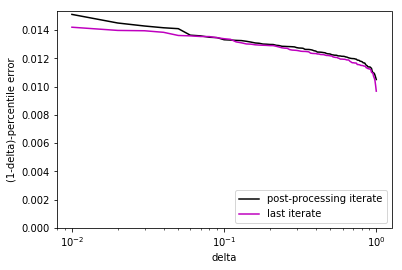

In [25]:
# Figure
fig, ax = plt.subplots()
ax.semilogx(1-cdf,b_errs,'-k',label='post-processing iterate')
ax.semilogx(1-cdf,l_errs,'-m',label='last iterate')
plt.xlabel('delta')
plt.ylabel('(1-delta)-percentile error')
plt.ylim(bottom=0)
legend = ax.legend(loc='lower right')
# plt.savefig('saconvergence.pdf')
plt.show()